# Eight Schools - An Edward/Stan Comparison

In this tutorial we fit the 8 schools model to data made famous by __[Stan](https://github.com/stan-dev/rstan/wiki/RStan-Getting-Started)__,  __[Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/)__ and first appearing in __[Rubin (1981) - (paywalled)](http://journals.sagepub.com/doi/abs/10.3102/10769986006004377)__.  The tutorial will be particularly suited to Stan users who are familiar with hierarchical models that would like to start using Edward.


In this example we introduce a slightly modified 8 Schools example and we compare Stan using the No-U-Turn sampler (NUTS) and Edward using Automatic Differentiation Variational Inference (ADVI/KLQP) and Hamiltonian Monte Carlo (HMC).  Both the Stan and Edward code are included in this tutorial and you may choose to install __[pystan](http://pystan.readthedocs.io/en/latest/getting_started.html)__ or __[rstan](https://github.com/stan-dev/rstan/wiki/RStan-Getting-Started)__ to run the Stan portions of code.  Comparison of Stan and Edward implementations can be a good way to check the algorithm and model is correct.  As we use our own Stan implementation of 8 schools our results will differ slightly with the improper priors used in the Stan __[getting started](https://github.com/stan-dev/rstan/wiki/RStan-Getting-Started)__ page and the Normal/Cauchy priors used in __[Diagnosing Biased Inference with Divergences](http://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html)__.  

We use the non-centered parameterization as advocated in __[Diagnosing Biased Inference with Divergences](http://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html)__ - which is highly recommended reading, just note all three models use slightly different priors when comparing results.

In the centered (and simplified) form eight schools is a hierarchical model:

$\mu \sim \mathcal{N}(0,10)$

$\log \tau \sim \mathcal{N}(5,1)$

$\theta \sim \mathcal{N}(\mu, (e^{ \log \tau})^2)$

$y_j \sim \mathcal{N}(\theta, \sigma^2_j)$

where $j \in [1..8]$ and $\{ y_j, \sigma_j \}$ are observed.

It may be easier to think of $\tau$ as the root variance, which we give a log normal prior to.



The non-centered model is equivalent and more suitable for inference and takes the following form:

$\mu \sim \mathcal{N}(0,10)$

$\log \tau \sim \mathcal{N}(5,1)$

$\theta' \sim \mathcal{N}(0,1)$

$y_j \sim \mathcal{N}(\mu + (e^{ \log \tau}) \theta', \sigma_j^2)$

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import edward as ed
import tensorflow as tf
from edward.models import Normal, Empirical
import matplotlib.pyplot as plt
import pystan

/Users/d.rohde/tensorflow3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# The Data

In [2]:
J = 8
data_y = np.array([28, 8, -3, 7, -1, 1, 18, 12])
data_sigma = np.array([15, 10, 16, 11, 9, 11, 10, 18])

# Edward Model Definition

Let's now define the same model using Edward:

In [3]:
mu = Normal(0., 10.)
logtau = Normal(5., 1.)
theta_prime = Normal(tf.zeros(J), tf.ones(J))
sigma = tf.placeholder(tf.float32, J)
y = Normal(mu + tf.exp(logtau) * theta_prime, sigma * tf.ones([J]))

In [4]:
data = {y: data_y, sigma: data_sigma}

# Edward Automatic Differentiation Variational Inference

We now use ed.KLqp to perform ADVI.  To do this we define the variational approximation family (as Gaussian) and then optimize the lower bound using Edwards ed.KLqp function.

In [5]:
with tf.variable_scope('q_logtau'):
    q_logtau = Normal(tf.get_variable('loc', []),
                      tf.nn.softplus(tf.get_variable('scale', [])))

with tf.variable_scope('q_mu'):
    q_mu = Normal(tf.get_variable('loc', []),
                  tf.nn.softplus(tf.get_variable('scale', [])))

with tf.variable_scope('q_theta_prime'):
    q_theta_prime = Normal(tf.get_variable('loc', [J]),
                           tf.nn.softplus(tf.get_variable('scale', [J])))


inference = ed.KLqp({logtau: q_logtau, mu: q_mu, theta_prime: q_theta_prime},
                    data=data)
inference.run(n_samples=15, n_iter=20000)

print("====    ed.KLqp inference ====")
print("E[mu] = %f" % (q_mu.mean().eval()))
print("E[logtau] = %f" % (q_logtau.mean().eval()))
print("E[theta_prime]=")
print((q_theta_prime.mean().eval()))
print("====  end ed.KLqp inference ====")

20000/20000 [100%] ██████████████████████████████ Elapsed: 56s | Loss: 37.511
====    ed.KLqp inference ====
E[mu] = 6.207960
E[logtau] = 2.298177
E[theta_prime]=
[ 0.65755504  0.08147718 -0.25415799  0.0358108  -0.36784816 -0.22100581
  0.55378842  0.13417724]
====  end ed.KLqp inference ====


In [6]:
# compute 95% interval for theta'
klqp_theta_prime_med = np.array(q_theta_prime.mean().eval())
klqp_theta_prime_hi = np.array(q_theta_prime.mean().eval() + 1.96 *
                               q_theta_prime.stddev().eval()
                               )
klqp_theta_prime_low = np.array(q_theta_prime.mean().eval() - 1.96 *
                                q_theta_prime.stddev().eval()
                                )

# transform theta' to theta with S Monte Carlo samples
S = 400000
klqp_theta = np.tile(q_mu.sample(S).eval(), [8, 1]
                     ).T + np.tile(np.exp(q_logtau.sample(S).eval()), [8, 1]
                                   ).T * q_theta_prime.sample(S).eval()
# compute 95% interval for theta
klqp_theta_low = np.array([np.percentile(klqp_theta[:, ii], 2.5)
                           for ii in range(8)])
klqp_theta_med = np.array([np.percentile(klqp_theta[:, ii], 50)
                           for ii in range(8)])
klqp_theta_hi = np.array([np.percentile(klqp_theta[:, ii], 97.5)
                          for ii in range(8)])

# Edward HMC inference

We now fit the same Edward model using HMC which is similar to Stan's NUTS algorithm but has more algorithm parameters to tune (although here we just use Edward's defaults).

This is similar to ADVI except that the approximating family is Edward's Empirical type and the sampling is performed using Edwards ed.HMC function.  Note: unlike Stan's self tuning NUTS algorithm HMC does need to be tuned for a particular problem.  Here we find the defaults work acceptably, but this cannot be assumed in general.

In [7]:
S = 100000
burn = S // 2
hq_logtau = Empirical(tf.Variable(tf.zeros([S])))
hq_mu = Empirical(tf.Variable(tf.zeros([S])))
hq_theta_prime = Empirical(tf.Variable(tf.zeros([S, J])))

inference = ed.HMC({logtau: hq_logtau, mu: hq_mu,
                    theta_prime: hq_theta_prime}, data=data)
inference.run()

print("====    ed.HMC inference ====")
print("E[mu] = %f" % (hq_mu.params.eval()[burn:].mean()))
print("E[logtau] = %f" % (hq_logtau.params.eval()[burn:].mean()))
print("E[theta_prime]=")
print(hq_theta_prime.params.eval()[burn:, ].mean(0))
print("====  end ed.HMC inference ====")

100000/100000 [100%] ██████████████████████████████ Elapsed: 114s | Acceptance Rate: 0.914
====    ed.HMC inference ====
E[mu] = 5.225341
E[logtau] = 2.454356
E[theta_prime]=
[ 0.66309202  0.11263941 -0.23707606  0.06023347 -0.31419596 -0.16834836
  0.57439238  0.14914863]
====  end ed.HMC inference ====


In [8]:
# compute 95% interval for theta'
hmc_theta_prime_low = np.array([np.percentile(
    hq_theta_prime.params.eval()[burn:, ii], 2.5) for ii in range(8)])
hmc_theta_prime_hi = np.array([np.percentile(
    hq_theta_prime.params.eval()[burn:, ii], 97.5) for ii in range(8)])
hmc_theta_prime_med = np.array([np.percentile(
    hq_theta_prime.params.eval()[burn:, ii], 50) for ii in range(8)])

# transform theta' to theta
hmc_theta = np.tile(hq_mu.params.eval()[burn:], [8, 1]
                    ).T + np.tile(np.exp(hq_logtau.params.eval()[burn:]), [8, 1]
                                  ).T * hq_theta_prime.params.eval()[burn:]

# compute 95% interval for theta
hmc_theta_low = np.array([np.percentile(hmc_theta[:, ii], 2.5)
                          for ii in range(8)])
hmc_theta_med = np.array([np.percentile(hmc_theta[:, ii], 50)
                          for ii in range(8)])
hmc_theta_hi = np.array([np.percentile(hmc_theta[:, ii], 97.5)
                         for ii in range(8)])

# Stan Model Definition

The Stan implementation of this non-centered model is:

In [9]:
eight_schools_stan = """
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real logtau;
  real theta_prime[J];
}

model {
  mu ~ normal(0, 10);
  logtau ~ normal(5, 1);
  theta_prime ~ normal(0, 1);
  for (j in 1:J) {
      y[j] ~ normal(mu + exp(logtau) * theta_prime[j], sigma[j]);
  }
}
"""

The Stan code quite closely follows the model definition.  Note that putting the Stan code in a string like this is convenient for this tutorial, but usually you should instead put the code in a separate file.

# Stan NUTS inference 

This allows us to run the Stan code (make sure pystan is installed for this step).

In [10]:
standata = dict(J=J, y=data_y, sigma=data_sigma)

fit = pystan.stan(model_code=eight_schools_stan,
                  data=standata, iter=20000)

s = fit.extract()
print("====  Stan/NUTS inference ====")
print("E[mu] = %f" % (s['mu'].mean()))
print("E[logtau] = %f" % (s['logtau'].mean()))
print("E[theta_prime]=")
print(s['theta_prime'].mean(0))
print("====  end Stan/NUTS inference ====")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d553225c2fc13d05db15363950aa04c0 NOW.


====  Stan/NUTS inference ====
E[mu] = 5.836806
E[logtau] = 2.450053
E[theta_prime]=
[ 0.64940756  0.09001582 -0.23279844  0.04471902 -0.33542507 -0.2041105
  0.53249937  0.14456798]
====  end Stan/NUTS inference ====


In [11]:
# compute 95% interval for theta'
stan_theta_prime_low = np.array([np.percentile(s['theta_prime'][:, ii], 2.5)
                                for ii in range(8)])
stan_theta_prime_hi = np.array([np.percentile(s['theta_prime'][:, ii], 97.5)
                                for ii in range(8)])
stan_theta_prime_med = np.array([np.percentile(s['theta_prime'][:, ii], 50)
                                for ii in range(8)])
# transform theta' to theta
stan_theta = np.tile(s['mu'],
                     [8, 1]
                     ) + np.tile(np.exp(s['logtau']), [8, 1]
                                 ) * s['theta_prime'].T
# compute 95% interval for theta
stan_theta_low = np.array([np.percentile(stan_theta[ii, ],
                                         2.5) for ii in range(8)])
stan_theta_hi = np.array([np.percentile(stan_theta[ii, ],
                                        97.5) for ii in range(8)])
stan_theta_med = np.array([np.percentile(stan_theta[ii, ],
                                         50) for ii in range(8)])

# Comparison of the approximate posteriors for $\theta'$


We can graphically show the the three methods have very similar $95\%$ intervals for $\theta'$:

Populating the interactive namespace from numpy and matplotlib


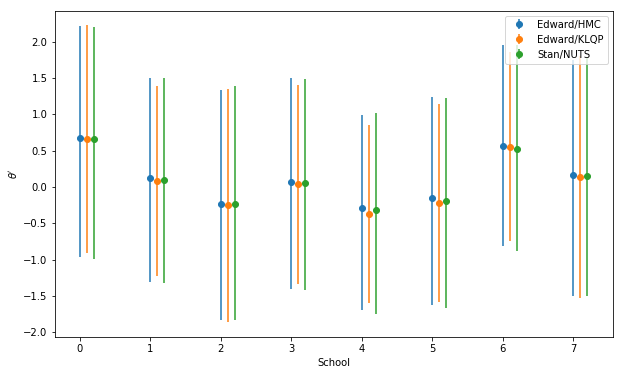

In [12]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

fig, ax = plt.subplots(nrows=1, sharex=True)

ax.errorbar(np.array(range(8)), hmc_theta_prime_med,
            yerr=[hmc_theta_prime_med - hmc_theta_prime_low,
                  hmc_theta_prime_hi - hmc_theta_prime_med], fmt='o')
ax.errorbar(np.array(range(8)) + 0.1, klqp_theta_prime_med,
            yerr=[klqp_theta_prime_med - klqp_theta_prime_low,
                  klqp_theta_prime_hi - klqp_theta_prime_med], fmt='o')
ax.errorbar(np.array(range(8)) + 0.2, stan_theta_prime_med,
            yerr=[stan_theta_prime_med - stan_theta_prime_low,
                  stan_theta_prime_hi - stan_theta_prime_med], fmt='o')
ax.legend(('Edward/HMC', 'Edward/KLQP', 'Stan/NUTS'))
plt.ylabel('$\\theta\'$')
plt.xlabel('School')
plt.show()


# Comparison of the approximate posteriors for $\theta$ and $y$

We can graphically show the the three methods have very similar $95\%$ intervals for $\theta$:

Populating the interactive namespace from numpy and matplotlib


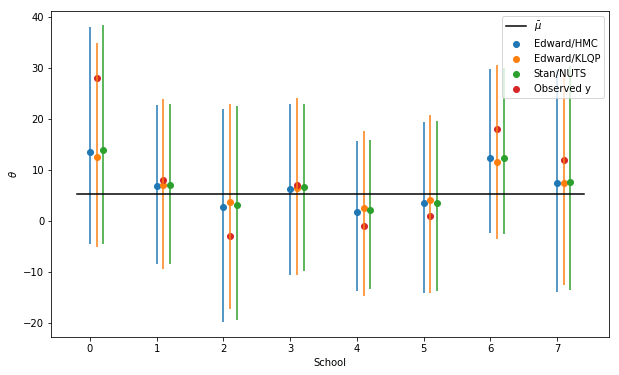

In [13]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
ax.scatter(np.array(range(8)), hmc_theta_med)
ax.scatter(np.array(range(8)) + 0.1, klqp_theta_med)
ax.scatter(np.array(range(8)) + 0.2, stan_theta_med)
ax.scatter(np.array(range(8)) + 0.1, data_y)

mu = hq_mu.params.eval()[burn:].mean()

plt.plot([-0.2, 7.4], [mu, mu], 'k')

ax.errorbar(np.array(range(8)), hmc_theta_med,
            yerr=[hmc_theta_med - hmc_theta_low,
                  hmc_theta_hi - hmc_theta_med], fmt='none')

ax.errorbar(np.array(range(8)) + 0.1, klqp_theta_med,
            yerr=[klqp_theta_med - klqp_theta_low,
                  klqp_theta_hi - klqp_theta_med],
            fmt='none')

ax.errorbar(np.array(range(8)) + 0.2, stan_theta_med,
            yerr=[stan_theta_med - stan_theta_low,
                  stan_theta_hi - stan_theta_med],
            fmt='none')


ax.legend(('$\\bar{\\mu}$', 'Edward/HMC', 'Edward/KLQP',
           'Stan/NUTS', 'Observed y'))


plt.xlabel('School')
plt.ylabel('$\\theta$')
plt.show()


The model makes an estimate of $\theta_j$ for each school which combines information from the score for that school $y_j$ and the global average schore $\mu$.  The prior on $\tau$ influences how much pooling occurs.  If $\tau$ is small then the pooling is strong and all schools have a similar $\theta_j$ and the uncertanity on $\theta_j$ decreases due to the sharing of information, if $\tau$ is large all schools will have a different $\theta_j$ with more uncertainty.

For the prior used here we observe a compromise, the median of $\theta_j$ is between $y_j$ and $\bar{\mu}$.

# Appendix R code for running through rstan

library(rstan)

rstan_options(auto_write = TRUE)

options(mc.cores = parallel::detectCores())

schools_dat <- list(J = 8,
                    y = c(28,  8, -3,  7, -1,  1, 18, 12),
                    sigma = c(15, 10, 16, 11,  9, 11, 10, 18))


fit <- stan(file = 'eight_schools.stan', data = schools_dat,iter = 100000, chains = 4)

print(fit)